In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file = 'ANZ_transactions.xlsx'
transactions = pd.read_excel(f'./data/{file}')

---

## Objective: `Targeted Marketing of Housing Loans to Customers`

---

### Data Inspection

In [4]:
transactions.head(3)

,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,...,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,...,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,...,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,...,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit


In [5]:
info = pd.DataFrame({
   'column': transactions.columns, 
   'total_null': transactions.isna().sum().values, 
   'na_%': np.round((transactions.isna().sum() / len(transactions)).values * 100, 2),
   'type': transactions.dtypes.values
}, index=range(1, transactions.shape[1] + 1)
)

In [6]:
info.column

1                status
2     card_present_flag
3      bpay_biller_code
4               account
5              currency
6              long_lat
7       txn_description
8           merchant_id
9         merchant_code
10           first_name
11              balance
12                 date
13               gender
14                  age
15      merchant_suburb
16       merchant_state
17           extraction
18               amount
19       transaction_id
20              country
21          customer_id
22    merchant_long_lat
23             movement
Name: column, dtype: object

In [7]:
info[info.total_null != 0]

,column,total_null,na_%,type
2,card_present_flag,4326,35.92,float64
3,bpay_biller_code,11158,92.65,object
8,merchant_id,4326,35.92,object
9,merchant_code,11160,92.67,float64
15,merchant_suburb,4326,35.92,object
16,merchant_state,4326,35.92,object
22,merchant_long_lat,4326,35.92,object


Columns like `bpay_biller_code` and `merchant_code` have high null rate. We need to dig a bit further

In [8]:
print('Dimension: ', transactions.shape)

Dimension:  (12043, 23)


---

### Descriptive Statistics

In [9]:
transactions.describe()

,card_present_flag,merchant_code,balance,age,amount
count,7717.000000,883.0,12043.000000,12043.000000,12043.000000
mean,0.802644,0.0,14704.195553,30.582330,187.933588
std,0.398029,0.0,31503.722652,10.046343,592.599934
min,0.000000,0.0,0.240000,18.000000,0.100000
25%,1.000000,0.0,3158.585000,22.000000,16.000000
50%,1.000000,0.0,6432.010000,28.000000,29.000000
75%,1.000000,0.0,12465.945000,38.000000,53.655000
max,1.000000,0.0,267128.520000,78.000000,8835.980000


---

## Exploratory Data Analysis

In [10]:
features = {
   'categorical': ['status', 'currency', 'txn_description', 'gender', 'merchant_suburb', 'merchant_state', 'country', 'movement'],
   'numerical': ['card_present_flag', 'balance', 'age', 'amount']
}

### Categorical Features

In [11]:
def value_counts_plot(feature: str, df: pd.DataFrame = transactions):
   """Plot a bar graph for the categorical feature <feature> in descending
   order and another bar graph for the average transaction amount by <feature>.
   Limit the plot to top 10 values.
   """
   fig, axes = plt.subplots(1, 2, figsize=(12,6))
   
   sns.countplot(data=df, x=feature, ax=axes[0]);
   sns.barplot(data=df, x=feature, y='amount', ax=axes[1])

   axes[0].set_title('Number of Transactions by ' + feature.capitalize())
   axes[1].set_title('Average Transaction Amount by ' + feature.capitalize())
   axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
   axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
   

`Status`

In [12]:
transactions.status.value_counts(dropna=False)

authorized    7717
posted        4326
Name: status, dtype: int64

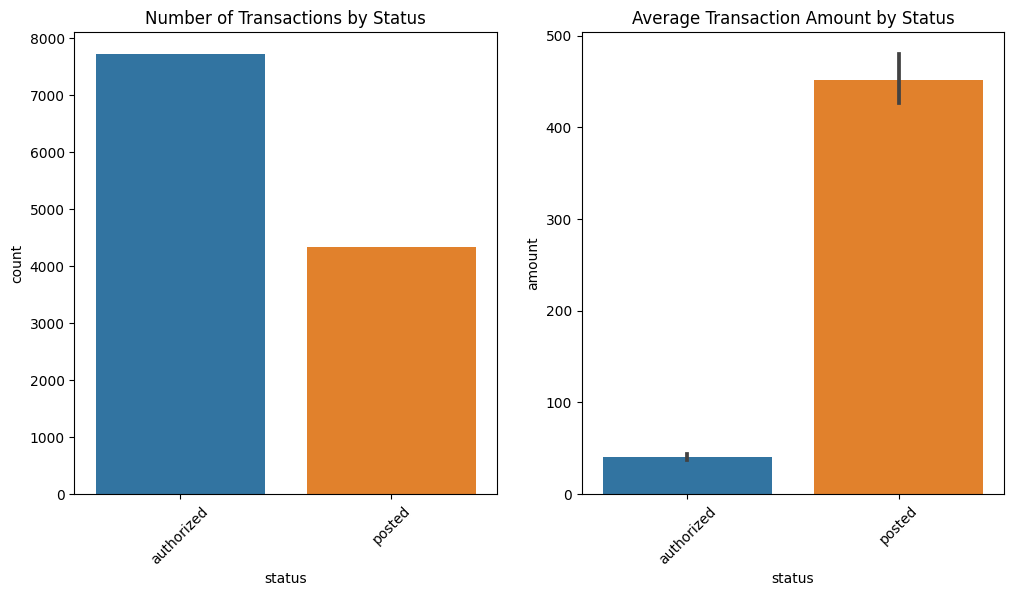

In [13]:
value_counts_plot(feature='status')

`Currency`

In [14]:
transactions.currency.value_counts(dropna=False)

AUD    12043
Name: currency, dtype: int64

`Transaction description`

In [15]:
transactions.txn_description.value_counts(dropna=False)

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

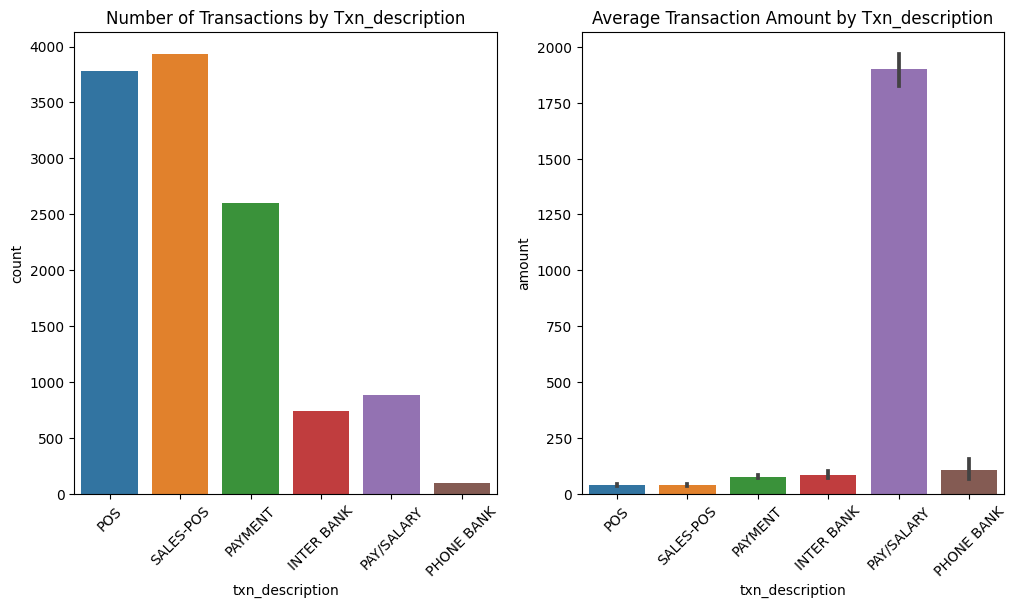

In [16]:
value_counts_plot(feature='txn_description')

`Gender`

In [17]:
transactions.gender.value_counts(dropna=False)

M    6285
F    5758
Name: gender, dtype: int64

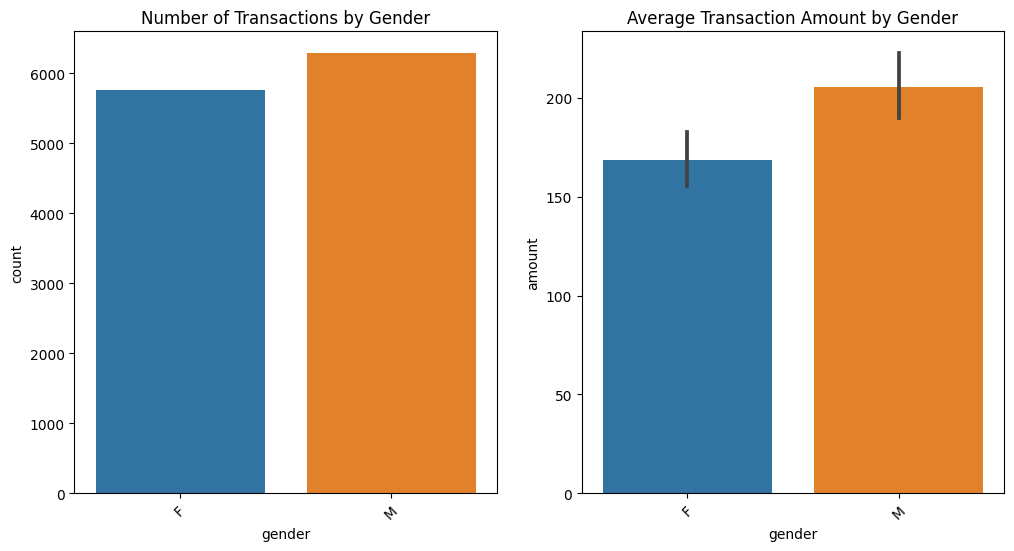

In [18]:
value_counts_plot(feature='gender')

`Merchant Suburb`

In [19]:
transactions.merchant_suburb.value_counts(dropna=False)

NaN                  4326
Melbourne             255
Sydney                233
Southport              82
Brisbane City          79
                     ... 
Cowell                  1
Tweed Heads South       1
Ballandean              1
Sydenham                1
Kings Park              1
Name: merchant_suburb, Length: 1610, dtype: int64

Most transactions were processed in `Melbourne` and `Sydney`

`Merchant State`

In [20]:
transactions.merchant_state.value_counts(dropna=False)

NaN    4326
NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merchant_state, dtype: int64

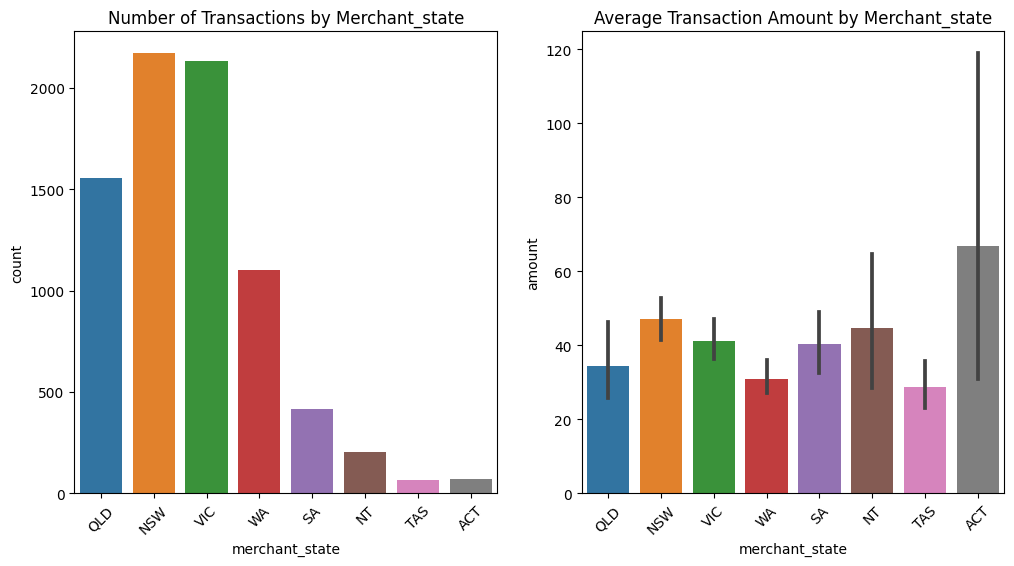

In [21]:
value_counts_plot(feature='merchant_state')

`Country`

In [22]:
transactions.country.value_counts(dropna=False)

Australia    12043
Name: country, dtype: int64

`Movement`: Method of payment

In [23]:
transactions.movement.value_counts(dropna=False)

debit     11160
credit      883
Name: movement, dtype: int64

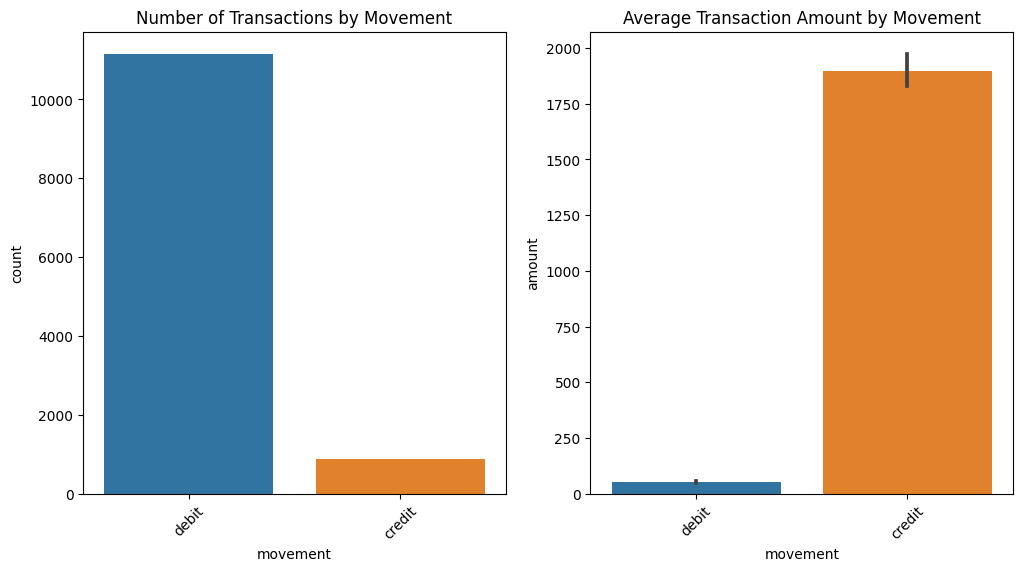

In [24]:
value_counts_plot(feature='movement')

There are transactions of a much higher average amount processed through credit. Should look more into this to see if there is any suspicious or fraud. 

`currency` and `country` show that all transactions are made in Australia in Australian dollar, that is a trivial fact. We may drop these two columns since they don't provide any additional information. 

In [25]:
if 'currency' in transactions.columns and 'country' in transactions.columns:
   del transactions['currency']
   del transactions['country']

In [26]:
transactions.shape

(12043, 21)

### Numerical Features

In [27]:
transactions.card_present_flag.value_counts(dropna=False)

1.0    6194
NaN    4326
0.0    1523
Name: card_present_flag, dtype: int64

How is balance distributed?

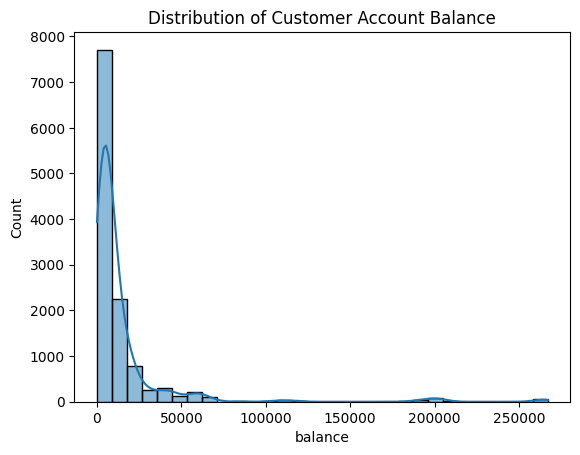

In [28]:
sns.histplot(data=transactions, x='balance', kde=True, bins=30);
plt.title('Distribution of Customer Account Balance');

How is customer age distributed?

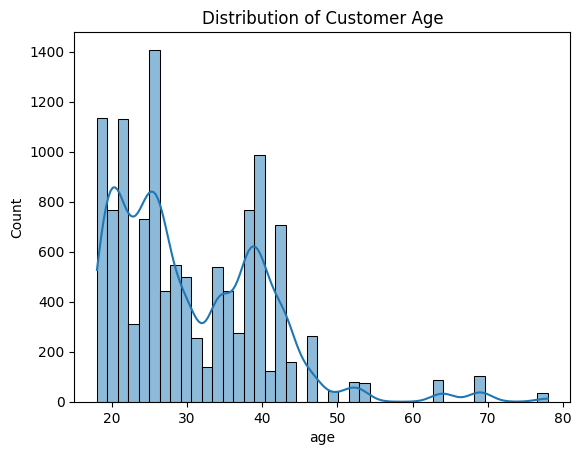

In [29]:
sns.histplot(data=transactions, x='age', kde=True);
plt.title('Distribution of Customer Age');

`There seems to be two groups of customers: one group of young adult (~23) and another group of middle-aged adult (~40)`

How is transaction amounts distributed?

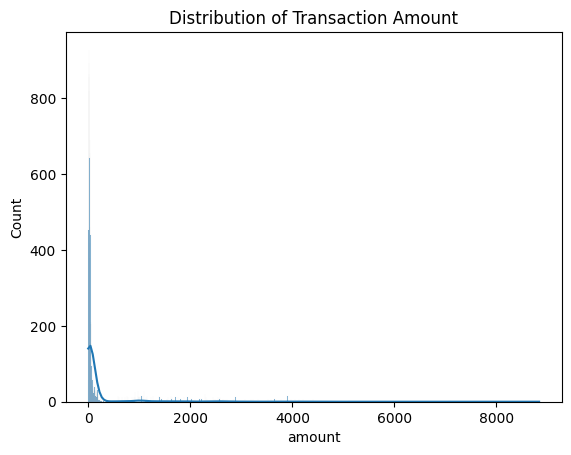

In [30]:
sns.histplot(data=transactions, x='amount', kde=True);
plt.title('Distribution of Transaction Amount');

### Handling Missing Values

In [31]:
info[info['total_null'] > 0].sort_values('na_%', ascending=False)

,column,total_null,na_%,type
9,merchant_code,11160,92.67,float64
3,bpay_biller_code,11158,92.65,object
2,card_present_flag,4326,35.92,float64
8,merchant_id,4326,35.92,object
15,merchant_suburb,4326,35.92,object
16,merchant_state,4326,35.92,object
22,merchant_long_lat,4326,35.92,object


`merchant_code` and `bpay_biller_code` contain too much missing values so they serve little use to the following analysis. Let's drop them both.

In [32]:
if 'merchant_code' in transactions.columns:
   del transactions['merchant_code']
if 'bpay_biller_code' in transactions.columns:
   del transactions['bpay_biller_code']

Recall that some transactions aren't made via POS and some are made through phone call or bank payment. Could these non-POS transactions be exactly those where the merchant and card info are missing? 

In [33]:
transactions.txn_description.unique()

array(['POS', 'SALES-POS', 'PAYMENT', 'INTER BANK', 'PAY/SALARY',
       'PHONE BANK'], dtype=object)

In [34]:
transactions[(transactions.txn_description != 'SALES-POS') & (transactions.txn_description != 'POS')].isna().sum().sort_values(ascending=False)

merchant_suburb      4326
merchant_long_lat    4326
merchant_id          4326
merchant_state       4326
card_present_flag    4326
status                  0
customer_id             0
transaction_id          0
amount                  0
extraction              0
gender                  0
age                     0
date                    0
balance                 0
first_name              0
txn_description         0
long_lat                0
account                 0
movement                0
dtype: int64

Exactly! These 4326 transactions are all non-POS transactions. They are still valid records so let's just impute them with NA values

In [35]:
impute_columns = ['merchant_state', 'merchant_id', 'merchant_long_lat', 'merchant_suburb', 'card_present_flag']

In [36]:
for col in impute_columns:
   transactions[col].fillna('N/A', inplace=True)

Double check that there is no null values

In [37]:
transactions.isna().sum()

status               0
card_present_flag    0
account              0
long_lat             0
txn_description      0
merchant_id          0
first_name           0
balance              0
date                 0
gender               0
age                  0
merchant_suburb      0
merchant_state       0
extraction           0
amount               0
transaction_id       0
customer_id          0
merchant_long_lat    0
movement             0
dtype: int64

## Feature Engineering

In [38]:
if 'month' not in transactions.columns:
   transactions['month'] = transactions.date.dt.month
if 'weekday' not in transactions.columns:
   transactions['weekday'] = transactions.date.dt.weekday
if 'month_name' not in transactions.columns:
   transactions['month_name'] = transactions.date.dt.month_name()
if 'day_name' not in transactions.columns:
   transactions['day_name'] = transactions.date.dt.day_name()

How many transactions do customers make each month on average? What's the average amount of transactions made each month?

In [39]:
transaction_month = transactions.groupby('month', as_index=False)
pd.DataFrame({
   'month': transaction_month.indices.keys(),
   'total_number': transaction_month.size()['size'],
   'average_amount': transaction_month.aggregate({'amount': 'mean'})['amount']
})

,month,total_number,average_amount
0,8,3943,185.121867
1,9,4013,182.045903
2,10,4087,196.427323


How many transactions do customers make each month on average?

In [40]:
monthly_average = transactions.groupby('customer_id').amount.sum().sort_values(ascending=False) / 3

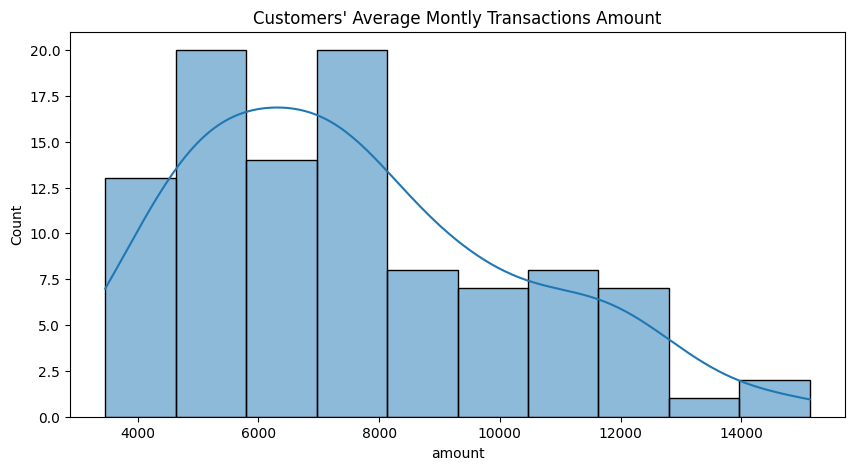

In [41]:
plt.figure(figsize=(10,5))
sns.histplot(data=monthly_average.to_frame(), x='amount', kde=True, bins=10);
plt.title('Customers\' Average Montly Transactions Amount');

How many transactions do customers make each week day on average? What's the average transaction amount made each day?

In [42]:
transaction_day = transactions.groupby('day_name', as_index=False)
pd.DataFrame({
   'day': transaction_day.indices.keys(),
   'total_number': transaction_day.size()['size'],
   'average_amount': transaction_day.aggregate({'amount': 'mean'})['amount']
})

,day,total_number,average_amount
0,Friday,2073,249.353517
1,Monday,1360,373.221000
2,Saturday,1709,54.419286
3,Sunday,1550,53.015845
4,Thursday,1801,184.010422
5,Tuesday,1487,221.576456
6,Wednesday,2063,195.215570


`Much less transactions amount occurs over the weekend.` Let's see how weekend activity compares with that during weekday 

In [43]:
if 'day_type' not in transactions:
   transactions['day_type'] = transactions['day_name'].apply(lambda day_name: 'weekend' if day_name == 'Saturday' or day_name == 'Sunday' else 'business day')

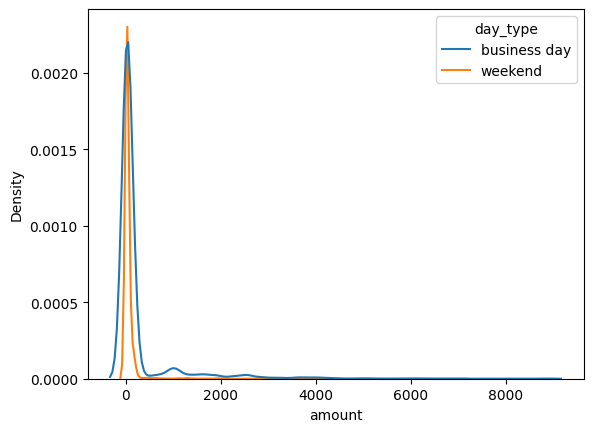

In [44]:
sns.kdeplot(data=transactions, x='amount', hue='day_type');

The distribution is heavily right-skewed so it's hard to determine any notable hidden patterns. Let's apply a logarithmic transformation to normalize it 

In [45]:
transactions['log_amount'] = transactions.amount.map(lambda amount: np.log(amount))

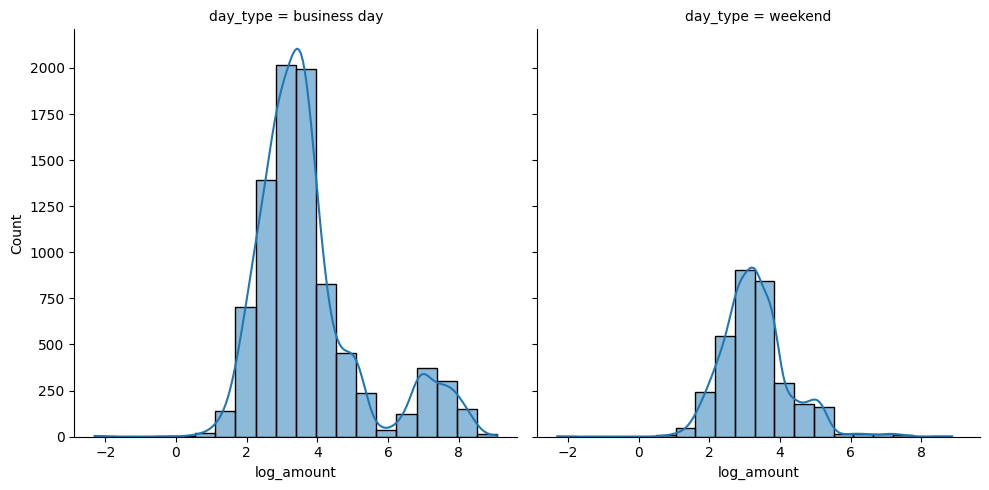

In [46]:
transactions_by_daytype = sns.FacetGrid(data=transactions, col='day_type', height=5)
transactions_by_daytype.map(sns.histplot, 'log_amount', kde=True, bins=20);

It looks like there are two notable groups of customer activities during week day: One group is revolved about `e^5 ≈ $148.41`; another group revolves about `e^7 ≈ $1096.63`

Let's see what types of transactions occur during the weekend

In [47]:
import seaborn.objects as so

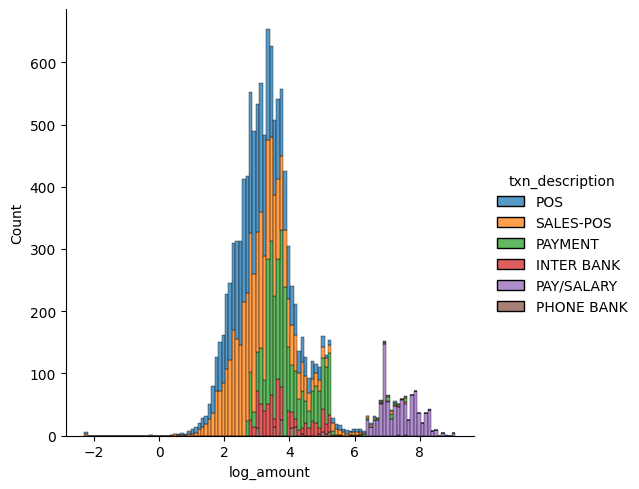

In [48]:
sns.displot(transactions, x='log_amount', hue='txn_description', multiple='stack');

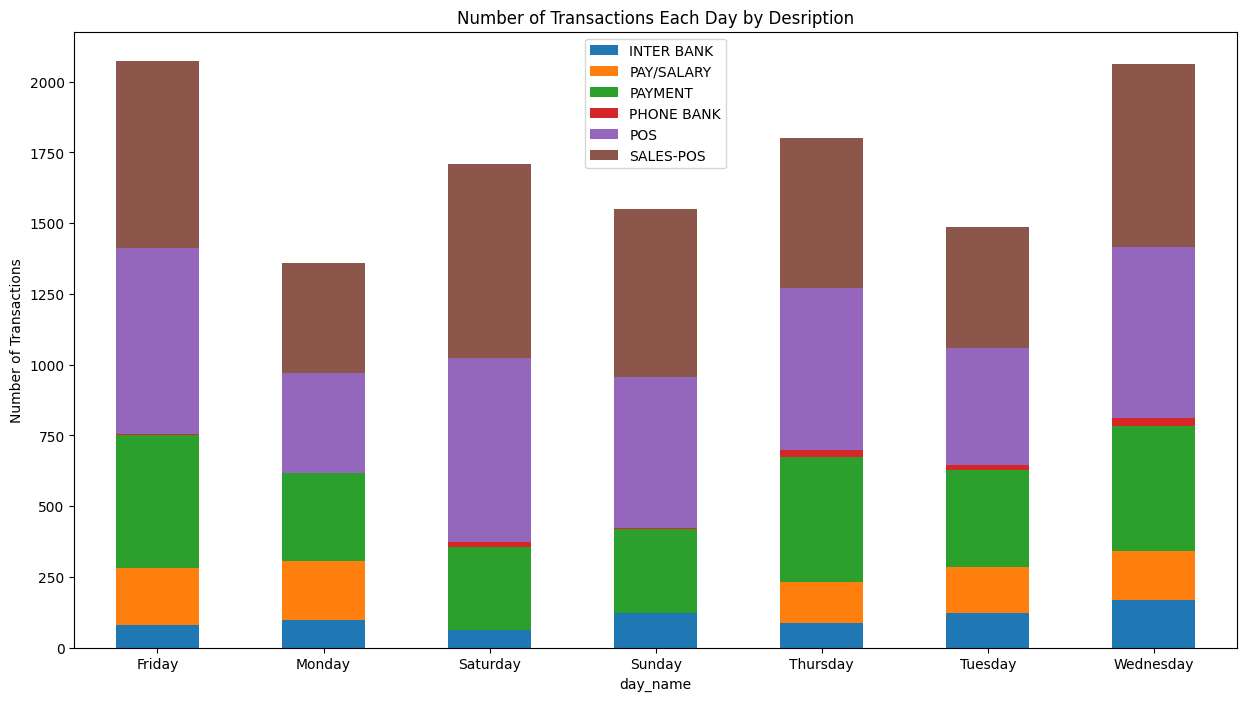

In [49]:
pd.DataFrame(transactions.groupby(['day_name', 'txn_description']).amount.size()).unstack().plot(kind='bar', stacked=True, figsize=(15,8));
plt.title('Number of Transactions Each Day by Desription');
plt.legend(['INTER BANK', 'PAY/SALARY', 'PAYMENT', 'PHONE BANK', 'POS', 'SALES-POS']);
plt.xticks(rotation='horizontal');
plt.ylabel('Number of Transactions');

The second group of more expensive activity turns out to be salary payment. And all salary activities took place during week day only so it make sense that less transactions of high amount occurred during weekend.

## Export Dataset for Second Task

In [50]:
transactions.to_csv(f'./data/ANZ_clean_transactions.csv')